# Notebook to Analyze HMI SHARP regions

## SHARP stands for Spaceweather HMI Active Region Patch.

Change the sharp number field to run and get the area contours.

In [2]:
from __future__ import division, print_function
import os.path
import matplotlib.pyplot as plt
from astropy.io import fits
import sunpy.cm as cm
import drms
import numpy as n
#%matplotlib inline


series = 'hmi.sharp_cea_720s'
sharpnum = 377 #sharp number
segments = ['magnetogram', 'continuum']
kwlist = ['T_REC', 'LON_FWT', 'OBS_VR', 'CROTA2',
          'CRPIX1', 'CRPIX2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2']

c = drms.Client(email='dash.soumya922@gmail.com', verbose=True) ##Use your own email address.
k = c.query('%s[%d]' % (series, sharpnum), key=kwlist, rec_index=True)

rec_cm = k.LON_FWT.abs().idxmin()
k_cm = k.loc[rec_cm]
t_cm = drms.to_datetime(k.T_REC[rec_cm])
print(rec_cm, '@', k.LON_FWT[rec_cm], 'deg')
print('Timestamp:', t_cm)

t_cm_str = t_cm.strftime('%Y%m%d_%H%M%S_TAI')
fname_mask = '{series}.{sharpnum}.{tstr}.{segment}.fits'
fnames = {
    s: fname_mask.format(
        series=series, sharpnum=sharpnum, tstr=t_cm_str, segment=s)
    for s in segments}

download_segments = []
for k, v in fnames.items():
    if not os.path.exists(v):
        download_segments.append(k)

if download_segments:
    exp_query = '%s{%s}' % (rec_cm, ','.join(download_segments))
    r = c.export(exp_query, method='url', protocol='fits')
    dl = r.download('.')

def read_fits_data(fname):
    """Reads FITS data and fixes/ignores any non-standard FITS keywords."""
    hdulist = fits.open(fname)
    hdulist.verify('silentfix+warn')
    return hdulist[1].data

mag = read_fits_data(fnames['magnetogram'])
cont = read_fits_data(fnames['continuum'])


hmi.sharp_cea_720s[377][2011.02.14_02:00:00_TAI] @ -0.038304000000000005 deg
Timestamp: 2011-02-14 02:00:00


In [3]:
ny, nx = mag.shape
xmin = (1 - k_cm.CRPIX1)*k_cm.CDELT1 + k_cm.CRVAL1
xmax = (nx - k_cm.CRPIX1)*k_cm.CDELT1 + k_cm.CRVAL1
ymin = (1 - k_cm.CRPIX2)*k_cm.CDELT2 + k_cm.CRVAL2
ymax = (ny - k_cm.CRPIX2)*k_cm.CDELT2 + k_cm.CRVAL2


x_data = n.linspace(xmin,xmax,nx)
y_data = n.linspace(ymin,ymax,ny)

In [4]:
import sunpy.map
a1 = sunpy.map.Map(fnames['magnetogram'])

## Calculate Area with 1sigma cut-off

In [5]:
lv1 = 150 #Standard deviation of the B distribution on the SHARP region
num_pixels = n.where(abs(mag) >= lv1)[0]

dx = 0.5*7.2e2 # 1 arcsec = 720 km; 1 arcsec= 7.2e2 km
dy = 0.5*7.2e2
da = dx*dy #in km^2
area_ar = num_pixels.size*da #area in km^2
r_sun = 6.96e5 #in km
unit_mh = 2.0*n.pi*r_sun**2 #1 hemisphere = 2piR_sun^2 #or ~1.54*10^6 km^2
area_calc = area_ar/(unit_mh)*1e6 ## Area in Micro Hemispheres
area_hdr = a1.meta['area_acr']
#(2.0*r_sun)/(31.5*60) #1 arcsec = 736.5 km

## Plot Images and save them

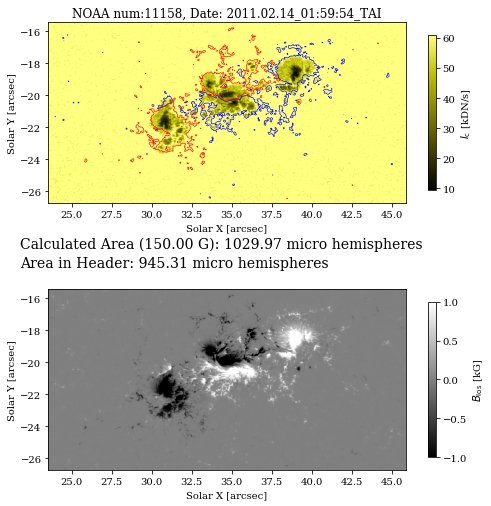

In [7]:
plt.rc('font',family='serif')

fig, ax = plt.subplots(2,1, figsize = (8,9))

hmimag = plt.get_cmap('gray')
cont_map = plt.get_cmap('sdoaia4500')

lv1 = 150.0
img_cont = ax[0].pcolormesh(x_data,y_data,cont/1e3,cmap=cont_map, vmax=61)
cb_cont = fig.colorbar(img_cont,ax=ax[0],label='$I_{\mathrm{c}}$ [kDN/s]',shrink=0.7)
pos_cont = ax[0].contour(x_data,y_data,mag,[lv1],colors='b',linewidths=0.65)
neg_cont = ax[0].contour(x_data,y_data,mag,[-lv1],colors='r',linewidths=0.65,linestyles='solid')

title_cont = 'NOAA num:'+str(a1.meta['noaa_ar'])+', Date: '+str(a1.meta['t_obs'])
ax[0].set_title(title_cont)
ax[0].axis('image')


img_mag = ax[1].pcolormesh(x_data,y_data,mag/1e3,cmap=hmimag, vmin=-1, vmax=1)
cb_mag = fig.colorbar(img_mag,ax=ax[1],label='$B_{\mathrm{los}}$ [kG]',shrink=0.7)
ax[1].axis('image')

fig.text(0.075,0.5,'Calculated Area ('+str("%5.2f" % lv1)+' G): '+str("%6.2f" %area_calc)+' micro hemispheres',fontsize=14)
fig.text(0.075,0.47,'Area in Header: '+str("%6.2f" %area_hdr)+' micro hemispheres',fontsize=14)

ax[1].set_xlabel('Solar X [arcsec]')
ax[0].set_xlabel('Solar X [arcsec]')
ax[0].set_ylabel('Solar Y [arcsec]')
ax[1].set_ylabel('Solar Y [arcsec]')


#fig.tight_layout()
#plt.subplots_adjust(hspace=0.4)
#plt.savefig('sharp_imgdata_'+str(sharpnum)+'.png', dpi=600,bbox='tight',pad_inches = 0)

plt.show()